In [18]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report, roc_auc_score, roc_curve
from sklearn.metrics import balanced_accuracy_score, matthews_corrcoef, precision_recall_curve, auc

# Pre-process dataset

In [19]:
df = pd.read_csv('../00_dataset/YelpZip/metadata', 
                 sep='\t',
                 header=None,
                 names=["user_id", "prod_id", "rating", "label", "date"])
df

,user_id,prod_id,rating,label,date
0,5044,0,1.0,-1,2014-11-16
1,5045,0,1.0,-1,2014-09-08
2,5046,0,3.0,-1,2013-10-06
3,5047,0,5.0,-1,2014-11-30
4,5048,0,5.0,-1,2014-08-28
...,...,...,...,...,...
608593,119664,5039,4.0,1,2013-01-20
608594,56277,5039,2.0,1,2012-11-12
608595,265320,5039,1.0,1,2012-08-22
608596,161722,5039,4.0,1,2011-05-11


In [20]:
# Check for Null values
df.isnull().sum()

user_id    0
prod_id    0
rating     0
label      0
date       0
dtype: int64

In [21]:
# Convert dataset into correct values
df['label'] = df['label'].replace({1: 0, -1: 1})
dataset_df = df
dataset_df

,user_id,prod_id,rating,label,date
0,5044,0,1.0,1,2014-11-16
1,5045,0,1.0,1,2014-09-08
2,5046,0,3.0,1,2013-10-06
3,5047,0,5.0,1,2014-11-30
4,5048,0,5.0,1,2014-08-28
...,...,...,...,...,...
608593,119664,5039,4.0,0,2013-01-20
608594,56277,5039,2.0,0,2012-11-12
608595,265320,5039,1.0,0,2012-08-22
608596,161722,5039,4.0,0,2011-05-11


# Create Train-test split

In [22]:
y = dataset_df['label']
X = dataset_df.drop('label', axis=1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

# Define Models that will be used in experiments

In [23]:
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier  # Boosting
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from xgboost import XGBClassifier

models = {
    "LR": LogisticRegression(),
    "NN": MLPClassifier(),
    "KNN": KNeighborsClassifier(),
    "DT": DecisionTreeClassifier(),
    "RF": RandomForestClassifier(),
    "AB": AdaBoostClassifier(),
    "XGB": XGBClassifier(),
    "NB": GaussianNB(),
}

results = []

for category, model in models.items():
    print(f"{category}: {model.__class__.__name__}")

LR: LogisticRegression
NN: MLPClassifier
KNN: KNeighborsClassifier
DT: DecisionTreeClassifier
RF: RandomForestClassifier
AB: AdaBoostClassifier
XGB: XGBClassifier
NB: GaussianNB


# Without Feature Engineering

### Convert and drop necessary columns
For date, we convert the date into a numerical format.

User_id and prod_id are unique identifiers of users and restaurants that were dropped from the dataset.

In [24]:
noFE_train, noFE_test, noFE_ytrain = X_train.copy(), X_test.copy(), y_train.copy()
noFE_train['date'] = pd.to_datetime(noFE_train['date']).astype('int64') // 10**9
noFE_test['date'] = pd.to_datetime(noFE_test['date']).astype('int64') // 10**9

noFE_train = noFE_train.drop(columns=["user_id", "prod_id"])
noFE_test = noFE_test.drop(columns=["user_id", "prod_id"])
temp = noFE_train.copy()
noFE_train

,rating,date
589867,4.0,1357084800
55546,4.0,1254009600
455503,4.0,1254009600
542977,2.0,1330387200
371326,5.0,1339372800
...,...,...
46211,5.0,1365638400
460939,4.0,1383955200
392385,5.0,1292889600
189210,4.0,1380499200


In [25]:
noFE_test

,rating,date
499916,4.0,1265673600
511252,1.0,1368835200
361411,5.0,1345507200
594296,1.0,1323475200
71596,4.0,1312675200
...,...,...
503917,3.0,1343952000
426264,5.0,1409788800
344648,4.0,1353974400
288962,1.0,1398297600


### Normalise data

In [26]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
noFE_train = scaler.fit_transform(noFE_train)
noFE_test = scaler.transform(noFE_test)
noFE_train.shape

(426018, 2)

### Visualise dataset distribution

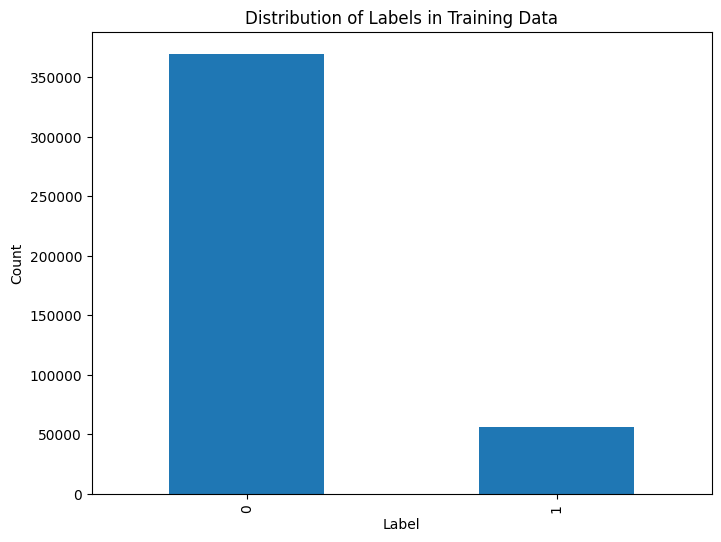

label
0    369692
1     56326
Name: count, dtype: int64


In [27]:
import matplotlib.pyplot as plt

label_counts = y_train.value_counts()

plt.figure(figsize=(8, 6))
label_counts.plot(kind='bar')
plt.xlabel('Label')
plt.ylabel('Count')
plt.title('Distribution of Labels in Training Data')
plt.show()

print(label_counts)

### Balancing the dataset
Due to the imbalanced dataset where Label:0 is significantly higher than Label:1, we utilised SMOTE to generate synthetic samples for our training data.

In [28]:
from imblearn.over_sampling import SMOTE
smote = SMOTE(sampling_strategy='auto', random_state=42)
noFE_train, noFE_ytrain = smote.fit_resample(noFE_train, noFE_ytrain)
noFE_train.shape

(739384, 2)

### Visualise the dataset after balancing

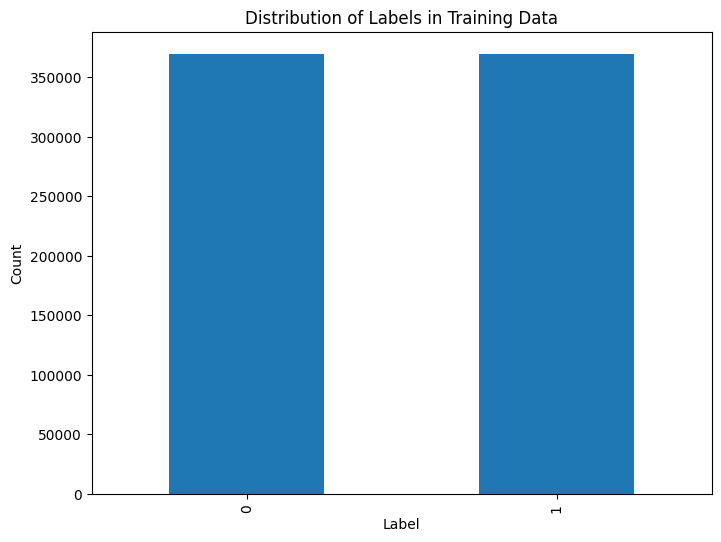

label
0    369692
1    369692
Name: count, dtype: int64


In [29]:
label_counts = noFE_ytrain.value_counts()

plt.figure(figsize=(8, 6))
label_counts.plot(kind='bar')
plt.xlabel('Label')
plt.ylabel('Count')
plt.title('Distribution of Labels in Training Data')
plt.show()

print(label_counts)

### Running evaluation on various models

In [30]:
for name, model in models.items():
    print(f"=== Model: {name} ===")
    model.fit(noFE_train, noFE_ytrain)
    y_pred = model.predict(noFE_test)
    
    # Evaluate metrics
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average='binary')  # Use 'macro' or 'weighted' for multiclass
    recall = recall_score(y_test, y_pred, average='binary')
    f1 = f1_score(y_test, y_pred, average='binary')
    conf_matrix = confusion_matrix(y_test, y_pred)
    print(f"Accuracy: {accuracy:.3f}, Precision: {precision:.3f}, Recall: {recall:.3f}, F1: {f1:.3f}")

    # print("\nConfusion Matrix:")
    # print(conf_matrix)
    # print("\nClassification Report:")
    # print(classification_report(y_test, y_pred))

    """
    OTHER METRICS
    """
    # Balanced accuracy
    balanced_acc = balanced_accuracy_score(y_test, y_pred)
    print(f"Balanced Accuracy: {balanced_acc:.3f}")

    # MCC
    mcc = matthews_corrcoef(y_test, y_pred)

    # get proba
    y_pred_proba = model.predict_proba(noFE_test)

    # ROC-AUC for both classes (Class 0 and Class 1)
    roc_auc_0 = roc_auc_score(y_test, y_pred_proba[:, 0])  # ROC-AUC for Class 0 (majority class)
    roc_auc_1 = roc_auc_score(y_test, y_pred_proba[:, 1])  # ROC-AUC for Class 1 (minority class)

    # PR-AUC for both classes
    precision_0, recall_0, _ = precision_recall_curve(y_test, y_pred_proba[:, 0])  # For Class 0
    pr_auc_0 = auc(recall_0, precision_0)

    precision_1, recall_1, _ = precision_recall_curve(y_test, y_pred_proba[:, 1])  # For Class 1
    pr_auc_1 = auc(recall_1, precision_1)

    results.append({
        "Model": name,
        "Accuracy": f"{accuracy:.4f}",
        "Precision": f"{precision:.4f}",
        "Recall": f"{recall:.4f}",
        "F1 Score": f"{f1:.4f}",
        "Balanced Accuracy": f"{balanced_acc:.4f}",
        "MCC": f"{mcc:.4f}",
        "PR-AUC_0": f"{pr_auc_0:.4f}",
        "PR-AUC_1": f"{pr_auc_1:.4f}",
        "ROC-AUC_0": f"{roc_auc_0:.4f}",
        "ROC-AUC_1": f"{roc_auc_1:.4f}"
    })

results_df = pd.DataFrame(results)

print("\n=== Model Evaluation Results ===")
print(results_df)

=== Model: LR ===
Accuracy: 0.560, Precision: 0.131, Recall: 0.412, F1: 0.198
Balanced Accuracy: 0.497
=== Model: NN ===
Accuracy: 0.578, Precision: 0.180, Recall: 0.618, F1: 0.279
Balanced Accuracy: 0.595
=== Model: KNN ===
Accuracy: 0.850, Precision: 0.247, Recall: 0.065, F1: 0.102
Balanced Accuracy: 0.517
=== Model: DT ===
Accuracy: 0.631, Precision: 0.176, Recall: 0.487, F1: 0.259
Balanced Accuracy: 0.570
=== Model: RF ===
Accuracy: 0.626, Precision: 0.176, Recall: 0.497, F1: 0.260
Balanced Accuracy: 0.571
=== Model: AB ===


c:\Users\cryst\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Accuracy: 0.574, Precision: 0.180, Recall: 0.624, F1: 0.279
Balanced Accuracy: 0.595
=== Model: XGB ===
Accuracy: 0.603, Precision: 0.185, Recall: 0.589, F1: 0.281
Balanced Accuracy: 0.597
=== Model: NB ===
Accuracy: 0.737, Precision: 0.173, Recall: 0.261, F1: 0.208
Balanced Accuracy: 0.535

=== Model Evaluation Results ===
  Model Accuracy Precision  Recall F1 Score Balanced Accuracy      MCC  \
0    LR   0.5602    0.1307  0.4116   0.1984            0.4972  -0.0038   
1    NN   0.5781    0.1803  0.6176   0.2791            0.5948   0.1291   
2   KNN   0.8503    0.2469  0.0645   0.1023            0.5173   0.0641   
3    DT   0.6312    0.1764  0.4874   0.2590            0.5703   0.0989   
4    RF   0.6261    0.1761  0.4971   0.2601            0.5714   0.1001   
5    AB   0.5744    0.1799  0.6237   0.2793            0.5953   0.1296   
6   XGB   0.6027    0.1850  0.5886   0.2815            0.5967   0.1327   
7    NB   0.7372    0.1727  0.2608   0.2078            0.5353   0.0597   

  PR-AU

In [31]:
results_df

,Model,Accuracy,Precision,Recall,F1 Score,Balanced Accuracy,MCC,PR-AUC_0,PR-AUC_1,ROC-AUC_0,ROC-AUC_1
0,LR,0.5602,0.1307,0.4116,0.1984,0.4972,-0.0038,0.1330,0.1626,0.4916,0.5084
1,NN,0.5781,0.1803,0.6176,0.2791,0.5948,0.1291,0.0998,0.2159,0.3718,0.6282
2,KNN,0.8503,0.2469,0.0645,0.1023,0.5173,0.0641,0.3099,0.1725,0.4459,0.5541
3,DT,0.6312,0.1764,0.4874,0.2590,0.5703,0.0989,0.1258,0.1918,0.4033,0.5967
4,RF,0.6261,0.1761,0.4971,0.2601,0.5714,0.1001,0.1208,0.1924,0.4028,0.5972
5,AB,0.5744,0.1799,0.6237,0.2793,0.5953,0.1296,0.0994,0.2224,0.3700,0.6300
6,XGB,0.6027,0.1850,0.5886,0.2815,0.5967,0.1327,0.0999,0.2168,0.3703,0.6297
7,NB,0.7372,0.1727,0.2608,0.2078,0.5353,0.0597,0.1095,0.1906,0.4209,0.5791


### Visualise feature importance (when using XGB)

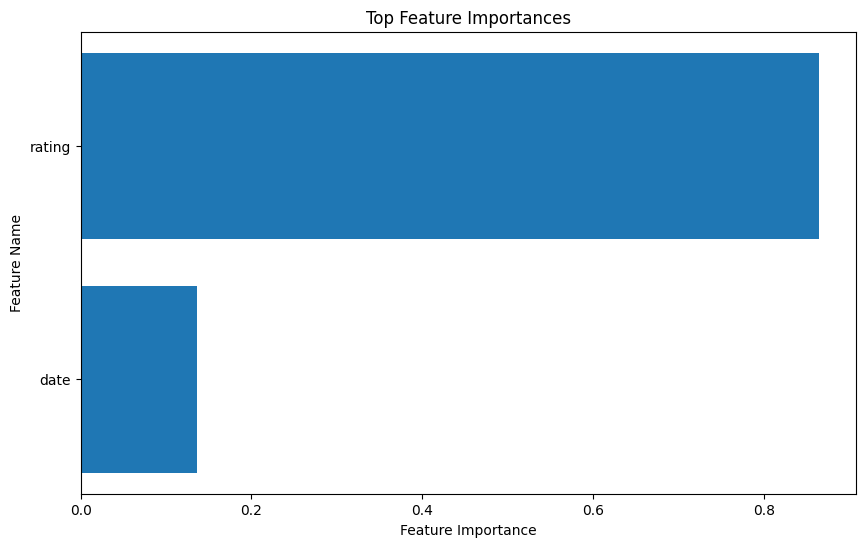

,Feature,Importance
0,rating,0.864104
1,date,0.135896


In [32]:
import matplotlib.pyplot as plt

xgclf = XGBClassifier(scale_pos_weight=len(noFE_ytrain[noFE_ytrain == 0]) / len(noFE_ytrain[noFE_ytrain == 1]))
xgclf.fit(noFE_train, noFE_ytrain)

# Get feature importance
feature_importance = xgclf.feature_importances_
feature_names = temp.columns

# Convert to DataFrame
feat_imp_df = pd.DataFrame({'Feature': feature_names, 'Importance': feature_importance})
feat_imp_df = feat_imp_df.sort_values(by='Importance', ascending=False)

# Plot feature importance
plt.figure(figsize=(10, 6))
plt.barh(feat_imp_df['Feature'][:20], feat_imp_df['Importance'][:20])
plt.xlabel('Feature Importance')
plt.ylabel('Feature Name')
plt.title('Top Feature Importances')
plt.gca().invert_yaxis()
plt.show()

# Display the top features
feat_imp_df.head()

In [33]:
results_df = results_df.sort_values(by="Model")
results_df

,Model,Accuracy,Precision,Recall,F1 Score,Balanced Accuracy,MCC,PR-AUC_0,PR-AUC_1,ROC-AUC_0,ROC-AUC_1
5,AB,0.5744,0.1799,0.6237,0.2793,0.5953,0.1296,0.0994,0.2224,0.3700,0.6300
3,DT,0.6312,0.1764,0.4874,0.2590,0.5703,0.0989,0.1258,0.1918,0.4033,0.5967
2,KNN,0.8503,0.2469,0.0645,0.1023,0.5173,0.0641,0.3099,0.1725,0.4459,0.5541
0,LR,0.5602,0.1307,0.4116,0.1984,0.4972,-0.0038,0.1330,0.1626,0.4916,0.5084
7,NB,0.7372,0.1727,0.2608,0.2078,0.5353,0.0597,0.1095,0.1906,0.4209,0.5791
1,NN,0.5781,0.1803,0.6176,0.2791,0.5948,0.1291,0.0998,0.2159,0.3718,0.6282
4,RF,0.6261,0.1761,0.4971,0.2601,0.5714,0.1001,0.1208,0.1924,0.4028,0.5972
6,XGB,0.6027,0.1850,0.5886,0.2815,0.5967,0.1327,0.0999,0.2168,0.3703,0.6297


### Apply feature engineering to train set

In [34]:
from UserFeatureEngineering import UserEngineer
from RestaurantFeatureEngineering import RestaurantEngineer

userFeatureEngineer = UserEngineer(X_train)
restaurantFeatureEngineer = RestaurantEngineer(X_train)

# Create the features and merge them with original dataset
user_features_train = userFeatureEngineer.aggregateTrainFeatures()
res_features_train = restaurantFeatureEngineer.aggregateTrainFeatures()

new_X_train = X_train.merge(res_features_train, on='prod_id', how='left').merge(user_features_train, on='user_id', how='left')

# Convert date to numerical form
new_X_train['date'] = pd.to_datetime(new_X_train['date']).astype('int64') // 10**9

new_X_train

,user_id,prod_id,rating,date,total_reviews_for_restaurant,avg_rating_for_restaurant,std_dev_rating_for_restaurant,median_rating_for_restaurant,review_frequency_for_restaurant,extreme_rating_index,...,rating_mean,rating_min,rating_max,rating_std,user_earliest,user_latest,user_days_active,user_review_timespan,users_avg_per_day,user_active_percentage
0,36136,4883,4.0,1357084800,74,4.297297,1.081979,5.0,11.216216,1.594595,...,4.029,2.0,5.0,0.797,1235779200,1388966400,31,1773,0.019,0.017
1,48075,495,4.0,1254009600,452,4.019912,1.036818,4.0,6.307522,1.285398,...,4.000,1.0,5.0,1.414,1254009600,1268784000,4,171,0.041,0.023
2,10252,3559,4.0,1254009600,431,4.171694,0.880400,4.0,4.742459,1.324826,...,3.812,1.0,5.0,0.814,1216252800,1420070400,52,2359,0.027,0.022
3,103017,4549,2.0,1330387200,83,3.385542,1.323625,4.0,16.337349,1.156627,...,3.000,2.0,5.0,1.265,1246233600,1343865600,5,1130,0.005,0.004
4,80246,3668,5.0,1339372800,296,3.783784,1.150036,4.0,9.354730,1.229730,...,5.000,5.0,5.0,0.000,1339372800,1339372800,1,1,1.000,1.000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
426013,41800,397,5.0,1365638400,27,4.222222,1.450022,5.0,86.777778,1.814815,...,5.000,5.0,5.0,0.000,1365638400,1365638400,1,1,1.000,1.000
426014,59926,3875,4.0,1383955200,2219,4.160433,0.885431,4.0,1.598468,1.279405,...,4.000,3.0,5.0,0.816,1377561600,1383955200,3,74,0.054,0.041
426015,12658,3314,5.0,1292889600,595,4.107563,1.045365,4.0,5.035294,1.366387,...,3.727,2.0,5.0,0.905,1292803200,1336003200,9,500,0.022,0.018
426016,118784,56,4.0,1380499200,1933,4.558200,0.688076,5.0,1.723228,1.596482,...,4.000,4.0,4.0,0.000,1299110400,1417132800,3,1366,0.002,0.002


### Add features found from train set to the test set
User and restaurant information from the train set acts as historical data of user or restaurant in the test set.

In [35]:
new_X_test = restaurantFeatureEngineer.updateTestRestaurants(X_test)
new_X_test = userFeatureEngineer.updateTestUsers(new_X_test)
new_X_test

,user_id,prod_id,rating,date,total_reviews_for_restaurant,avg_rating_for_restaurant,std_dev_rating_for_restaurant,median_rating_for_restaurant,review_frequency_for_restaurant,extreme_rating_index,...,rating_mean,rating_min,rating_max,rating_std,user_earliest,user_latest,user_days_active,user_review_timespan,users_avg_per_day,user_active_percentage
0,15990,4148,4.0,1265673600,1105,3.958371,0.934487,4.0,2.993665,1.157466,...,4.120000,3.000000,5.000000,0.526,1202947200,1397088000,23,2247,0.011,0.010
1,236532,4241,1.0,1368835200,17,3.823529,1.236694,4.0,127.470588,1.294118,...,3.937755,3.937755,3.937755,0.000,1368835200,1368835200,1,1,1.000,1.000
2,19006,4231,5.0,1345507200,63,4.301587,0.891445,4.0,14.174603,1.460317,...,3.810000,2.000000,5.000000,0.804,1225929600,1412467200,37,2159,0.019,0.017
3,13244,4941,1.0,1323475200,218,4.077982,0.982976,4.0,7.114679,1.288991,...,4.500000,4.000000,5.000000,0.707,1371254400,1413936000,2,494,0.004,0.004
4,41502,629,4.0,1312675200,370,3.989189,0.948479,4.0,6.062162,1.200000,...,4.667000,4.000000,5.000000,0.577,1282348800,1312675200,3,351,0.009,0.009
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
182575,10322,4162,3.0,1343952000,78,4.000000,0.939743,4.0,12.179487,1.179487,...,3.636000,3.000000,5.000000,0.674,1298678400,1371772800,7,846,0.013,0.008
182576,8419,3677,5.0,1409788800,650,3.895385,1.072766,4.0,2.072308,1.212308,...,3.655000,2.000000,5.000000,0.897,1310688000,1416096000,26,1220,0.024,0.021
182577,132872,3003,4.0,1353974400,729,4.034294,1.057510,4.0,1.525377,1.308642,...,4.400000,4.000000,5.000000,0.548,1312329600,1342396800,4,348,0.014,0.011
182578,160774,52,1.0,1398297600,487,3.790554,1.131877,4.0,6.809035,1.201232,...,3.937755,3.937755,3.937755,0.000,1398297600,1398297600,1,1,1.000,1.000


### Drop unique identifiers after features are properly concatenated

In [36]:
new_X_train = new_X_train.drop(columns=["user_id", "prod_id"], errors="ignore")
new_X_test = new_X_test.drop(columns=["user_id", "prod_id"], errors="ignore")

print(new_X_train.shape, new_X_test.shape)

(426018, 19) (182580, 19)


### Apply normalisation

In [37]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

new_X_train = pd.DataFrame(scaler.fit_transform(new_X_train), columns=new_X_train.columns)
new_X_test = pd.DataFrame(scaler.transform(new_X_test), columns=new_X_test.columns)
new_X_train

,rating,date,total_reviews_for_restaurant,avg_rating_for_restaurant,std_dev_rating_for_restaurant,median_rating_for_restaurant,review_frequency_for_restaurant,extreme_rating_index,user_restaurants_reviewed,rating_mean,rating_min,rating_max,rating_std,user_earliest,user_latest,user_days_active,user_review_timespan,users_avg_per_day,user_active_percentage
0,0.067076,0.180550,-0.600955,0.983145,0.042416,1.650693,-0.136756,1.705860,1.952200,0.116298,-0.807427,0.522731,0.402652,-1.442297,0.401127,2.115707,2.077833,-0.630304,-0.833008
1,0.067076,-1.596707,-0.177284,0.254536,-0.200702,-0.234993,-0.290291,-0.077371,-0.077782,0.084478,-1.542987,0.522731,1.479226,-1.155516,-1.870909,-0.238274,-0.470213,-0.603570,-0.820867
2,0.067076,-1.596707,-0.200821,0.653222,-1.042758,-0.234993,-0.339244,0.150021,4.207737,-0.121801,-1.542987,0.522731,0.432314,-1.749465,0.989145,3.946581,3.009889,-0.620583,-0.822890
3,-1.675342,-0.279779,-0.590868,-1.411760,1.343291,-0.234993,0.023425,-0.820037,-0.152967,-1.012754,-0.807427,0.522731,1.219243,-1.277839,-0.451499,-0.151090,1.055115,-0.647317,-0.859314
4,0.938285,-0.124846,-0.352132,-0.365700,0.408797,-0.234993,-0.194980,-0.398428,-0.528890,1.181710,1.399255,0.522731,-0.987996,0.187325,-0.536435,-0.499828,-0.740605,0.561804,1.156128
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
426013,0.938285,0.328034,-0.653634,0.785945,2.023733,1.650693,2.226683,2.975938,-0.528890,1.181710,1.399255,0.522731,-0.987996,0.600507,-0.039887,-0.499828,-0.740605,0.561804,1.156128
426014,0.067076,0.643858,1.803213,0.623643,-1.015673,-0.234993,-0.437582,-0.111935,-0.303336,0.084478,-0.071866,0.522731,0.435804,0.788070,0.306390,-0.325459,-0.624496,-0.587772,-0.784443
426015,0.938285,-0.926325,-0.017006,0.484770,-0.154689,-0.234993,-0.330084,0.389714,0.222956,-0.215066,-0.807427,0.522731,0.591096,-0.545257,-0.600137,0.197648,0.053075,-0.626659,-0.830984
426016,0.067076,0.584269,1.482658,1.668457,-2.078110,1.650693,-0.433680,1.716746,-0.378521,0.084478,0.663694,-0.520606,-0.987996,-0.446039,0.933610,-0.325459,1.430483,-0.650963,-0.863361


### Balance dataset

In [38]:
from imblearn.over_sampling import SMOTE

smote = SMOTE(sampling_strategy='auto', random_state=42)
new_X_train, y_train = smote.fit_resample(new_X_train, y_train)
new_X_train

,rating,date,total_reviews_for_restaurant,avg_rating_for_restaurant,std_dev_rating_for_restaurant,median_rating_for_restaurant,review_frequency_for_restaurant,extreme_rating_index,user_restaurants_reviewed,rating_mean,rating_min,rating_max,rating_std,user_earliest,user_latest,user_days_active,user_review_timespan,users_avg_per_day,user_active_percentage
0,0.067076,0.180550,-0.600955,0.983145,0.042416,1.650693,-0.136756,1.705860,1.952200,0.116298,-0.807427,0.522731,0.402652,-1.442297,0.401127,2.115707,2.077833,-0.630304,-0.833008
1,0.067076,-1.596707,-0.177284,0.254536,-0.200702,-0.234993,-0.290291,-0.077371,-0.077782,0.084478,-1.542987,0.522731,1.479226,-1.155516,-1.870909,-0.238274,-0.470213,-0.603570,-0.820867
2,0.067076,-1.596707,-0.200821,0.653222,-1.042758,-0.234993,-0.339244,0.150021,4.207737,-0.121801,-1.542987,0.522731,0.432314,-1.749465,0.989145,3.946581,3.009889,-0.620583,-0.822890
3,-1.675342,-0.279779,-0.590868,-1.411760,1.343291,-0.234993,0.023425,-0.820037,-0.152967,-1.012754,-0.807427,0.522731,1.219243,-1.277839,-0.451499,-0.151090,1.055115,-0.647317,-0.859314
4,0.938285,-0.124846,-0.352132,-0.365700,0.408797,-0.234993,-0.194980,-0.398428,-0.528890,1.181710,1.399255,0.522731,-0.987996,0.187325,-0.536435,-0.499828,-0.740605,0.561804,1.156128
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
739379,-2.546551,-0.648763,-0.650162,-1.855329,2.669673,-2.120678,2.031442,0.268626,-0.528890,-3.207217,-1.542987,-3.650617,-0.987996,-0.290666,-1.110870,-0.499828,-0.740605,0.561804,1.156128
739380,0.067076,0.373513,-0.395531,0.036755,-0.706592,-0.234993,-0.274463,-0.855301,-0.378521,0.084478,-0.071866,0.522731,0.756857,0.642000,0.009977,-0.499828,-0.740605,2.992198,1.156128
739381,0.938285,0.312641,0.262144,-0.028427,-0.190885,-0.234993,-0.368138,-0.481373,-0.528890,1.181710,1.399255,0.522731,-0.987996,0.586464,-0.056764,-0.499828,-0.740605,0.561804,1.156128
739382,-0.804133,-0.472654,-0.242797,-0.195839,0.834888,-0.234993,-0.225520,0.199407,-0.528890,-1.012754,-0.071866,-1.563943,-0.987996,-0.129994,-0.917780,-0.499828,-0.740605,0.561804,1.156128


In [39]:
new_X_train.isnull().sum()

rating                             0
date                               0
total_reviews_for_restaurant       0
avg_rating_for_restaurant          0
std_dev_rating_for_restaurant      0
median_rating_for_restaurant       0
review_frequency_for_restaurant    0
extreme_rating_index               0
user_restaurants_reviewed          0
rating_mean                        0
rating_min                         0
rating_max                         0
rating_std                         0
user_earliest                      0
user_latest                        0
user_days_active                   0
user_review_timespan               0
users_avg_per_day                  0
user_active_percentage             0
dtype: int64

In [40]:
new_X_test.isnull().sum()

rating                             0
date                               0
total_reviews_for_restaurant       0
avg_rating_for_restaurant          0
std_dev_rating_for_restaurant      0
median_rating_for_restaurant       0
review_frequency_for_restaurant    0
extreme_rating_index               0
user_restaurants_reviewed          0
rating_mean                        0
rating_min                         0
rating_max                         0
rating_std                         0
user_earliest                      0
user_latest                        0
user_days_active                   0
user_review_timespan               0
users_avg_per_day                  0
user_active_percentage             0
dtype: int64

# Train model
**Balanced Accuracy** is the average of sensitivity (recall) and specificity. It's used to evaluate models when the dataset is imbalanced, as it provides a more balanced measure of the model's performance across both classes.\
\
**Matthews Corelation Coefficient (MCC)**: is a measure of the quality of binary (two-class) classifications. Unlike accuracy, precision, or recall, it considers all four quadrants of the confusion matrix. \
1 indicates perfect prediction.
0 indicates random prediction.
-1 indicates total disagreement between prediction and truth (e.g., if the model predicts everything wrong).\
\
**PR-AUC** is the area under the Precision-Recall curve, which plots Precision (positive predictive value) vs Recall (sensitivity) for different thresholds of classification.\
1 indicates perfect precision and recall.
0 indicates no precision or recall (i.e., the model is performing terribly).

**ROC-AUC** measures the area under the ROC curve, which plots True Positive Rate (TPR) vs False Positive Rate (FPR) for different classification thresholds.\
1 indicates perfect model, 0.5 indicates random guessing.

In [41]:
for name, model in models.items():
    print(f"=== Model: {name} ===")
    
    model.fit(new_X_train, y_train)
    y_pred = model.predict(new_X_test)

    # Evaluate metrics
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average='binary')  # Use 'macro' or 'weighted' for multiclass
    recall = recall_score(y_test, y_pred, average='binary')
    f1 = f1_score(y_test, y_pred, average='binary')
    conf_matrix = confusion_matrix(y_test, y_pred)

    print(f"Accuracy: {accuracy:.3f}, Precision: {precision:.3f}, Recall: {recall:.3f}, F1: {f1:.3f}")
    # print("\nConfusion Matrix:")
    # print(conf_matrix)
    # print("\nClassification Report:")
    # print(classification_report(y_test, y_pred))

    """
    OTHER METRICS
    """
    # Balanced accuracy
    balanced_acc = balanced_accuracy_score(y_test, y_pred)
    print(f"Balanced Accuracy: {balanced_acc:.3f}")

    # MCC
    mcc = matthews_corrcoef(y_test, y_pred)

    # PR-AUC
    y_pred_proba = model.predict_proba(new_X_test)


    # ROC-AUC for both classes (Class 0 and Class 1)
    roc_auc_0 = roc_auc_score(y_test, y_pred_proba[:, 0])  # ROC-AUC for Class 0 (minority class)
    roc_auc_1 = roc_auc_score(y_test, y_pred_proba[:, 1])  # ROC-AUC for Class 1 (majority class)

    # PR-AUC for both classes
    precision_0, recall_0, _ = precision_recall_curve(y_test, y_pred_proba[:, 0])  # For Class 0
    pr_auc_0 = auc(recall_0, precision_0)

    precision_1, recall_1, _ = precision_recall_curve(y_test, y_pred_proba[:, 1])  # For Class 1
    pr_auc_1 = auc(recall_1, precision_1)

    # print(f"Balanced Accuracy: {balanced_acc:.3f}")
    # print(f"Matthews Correlation Coefficient: {mcc:.3f}")
    # print(f"PR-AUC for class 0: {pr_auc_0:.3f}")
    # print(f"PR-AUC for class 1: {pr_auc_1:.3f}")

    results.append({
        "Model": f"{name}_FE",
        "Accuracy": f"{accuracy:.4f}",
        "Precision": f"{precision:.4f}",
        "Recall": f"{recall:.4f}",
        "F1 Score": f"{f1:.4f}",
        "Balanced Accuracy": f"{balanced_acc:.4f}",
        "MCC": f"{mcc:.4f}",
        "PR-AUC_0": f"{pr_auc_0:.4f}",
        "PR-AUC_1": f"{pr_auc_1:.4f}",
        "ROC-AUC_0": f"{roc_auc_0:.4f}",
        "ROC-AUC_1": f"{roc_auc_1:.4f}"
    })

# Convert results to a DataFrame
results_df = pd.DataFrame(results)

# Sort the results by "Model" alphabetically
results_df = results_df.sort_values(by="Model")

# Display the results table
print("\n=== Model Evaluation Results ===")
print(results_df)

=== Model: LR ===
Accuracy: 0.580, Precision: 0.228, Recall: 0.911, F1: 0.364
Balanced Accuracy: 0.720
=== Model: NN ===


c:\Users\cryst\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


Accuracy: 0.770, Precision: 0.265, Recall: 0.418, F1: 0.324
Balanced Accuracy: 0.621
=== Model: KNN ===
Accuracy: 0.711, Precision: 0.246, Recall: 0.576, F1: 0.345
Balanced Accuracy: 0.654
=== Model: DT ===
Accuracy: 0.786, Precision: 0.292, Recall: 0.435, F1: 0.349
Balanced Accuracy: 0.637
=== Model: RF ===
Accuracy: 0.811, Precision: 0.348, Recall: 0.494, F1: 0.408
Balanced Accuracy: 0.677
=== Model: AB ===


c:\Users\cryst\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Accuracy: 0.600, Precision: 0.233, Recall: 0.885, F1: 0.369
Balanced Accuracy: 0.721
=== Model: XGB ===
Accuracy: 0.652, Precision: 0.256, Recall: 0.857, F1: 0.394
Balanced Accuracy: 0.739
=== Model: NB ===
Accuracy: 0.544, Precision: 0.216, Recall: 0.934, F1: 0.351
Balanced Accuracy: 0.709

=== Model Evaluation Results ===
     Model Accuracy Precision  Recall F1 Score Balanced Accuracy      MCC  \
5       AB   0.5744    0.1799  0.6237   0.2793            0.5953   0.1296   
13   AB_FE   0.6004    0.2333  0.8847   0.3693            0.7209   0.2993   
3       DT   0.6312    0.1764  0.4874   0.2590            0.5703   0.0989   
11   DT_FE   0.7858    0.2918  0.4345   0.3492            0.6369   0.2333   
2      KNN   0.8503    0.2469  0.0645   0.1023            0.5173   0.0641   
10  KNN_FE   0.7112    0.2464  0.5757   0.3452            0.6538   0.2254   
0       LR   0.5602    0.1307  0.4116   0.1984            0.4972  -0.0038   
8    LR_FE   0.5796    0.2276  0.9108   0.3642            

In [45]:
results_df

,Model,Accuracy,Precision,Recall,F1 Score,Balanced Accuracy,MCC,PR-AUC_0,PR-AUC_1,ROC-AUC_0,ROC-AUC_1
5,AB,0.5744,0.1799,0.6237,0.2793,0.5953,0.1296,0.0994,0.2224,0.3700,0.6300
13,AB_FE,0.6004,0.2333,0.8847,0.3693,0.7209,0.2993,0.0806,0.2913,0.2233,0.7767
3,DT,0.6312,0.1764,0.4874,0.2590,0.5703,0.0989,0.1258,0.1918,0.4033,0.5967
11,DT_FE,0.7858,0.2918,0.4345,0.3492,0.6369,0.2333,0.3562,0.4004,0.3620,0.6380
2,KNN,0.8503,0.2469,0.0645,0.1023,0.5173,0.0641,0.3099,0.1725,0.4459,0.5541
10,KNN_FE,0.7112,0.2464,0.5757,0.3452,0.6538,0.2254,0.1783,0.3199,0.2899,0.7101
0,LR,0.5602,0.1307,0.4116,0.1984,0.4972,-0.0038,0.1330,0.1626,0.4916,0.5084
8,LR_FE,0.5796,0.2276,0.9108,0.3642,0.7200,0.2986,0.0805,0.2975,0.2233,0.7767
7,NB,0.7372,0.1727,0.2608,0.2078,0.5353,0.0597,0.1095,0.1906,0.4209,0.5791
15,NB_FE,0.5444,0.2165,0.9336,0.3514,0.7094,0.2865,0.0860,0.2773,0.2328,0.7676


In [46]:
results_df.to_csv("b1_results.csv")

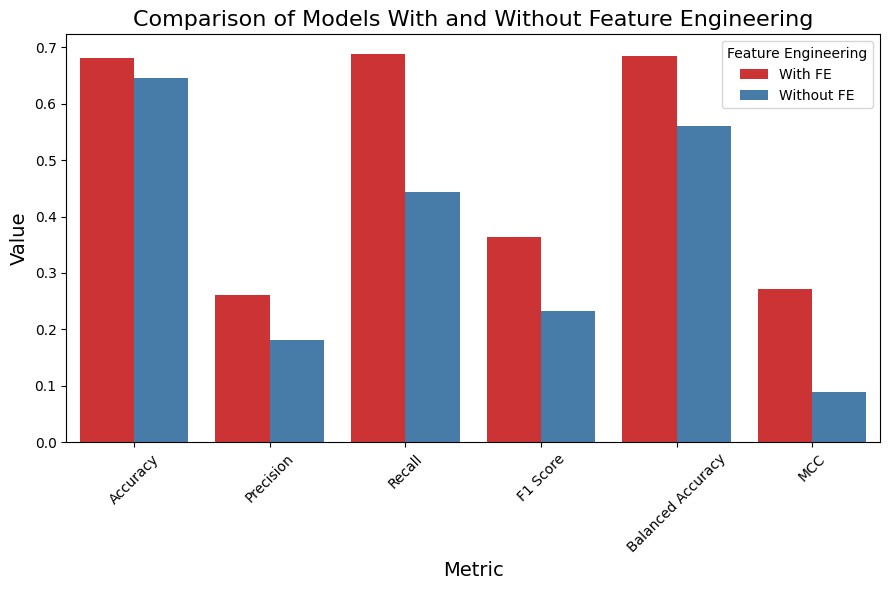

In [66]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

results_df = pd.read_csv("b1_results.csv")

results_df["FE"] = results_df["Model"].apply(lambda x: "With FE" if "_FE" in x else "Without FE")
# numeric_columns = results_df.select_dtypes(include=["number"]).columns
grouped = results_df.groupby("FE")[["Accuracy", "Precision", "Recall", "F1 Score", "Balanced Accuracy", "MCC"]].mean().reset_index()
plt.figure(figsize=(9, 6))

melted = grouped.melt(id_vars="FE", var_name="Metric", value_name="Value")

sns.barplot(data=melted, x="Metric", y="Value", hue="FE", palette="Set1")

plt.title("Comparison of Models With and Without Feature Engineering", fontsize=16)
plt.xlabel("Metric", fontsize=14)
plt.ylabel("Value", fontsize=14)
plt.legend(title="Feature Engineering")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Check Feature Importance using xgb

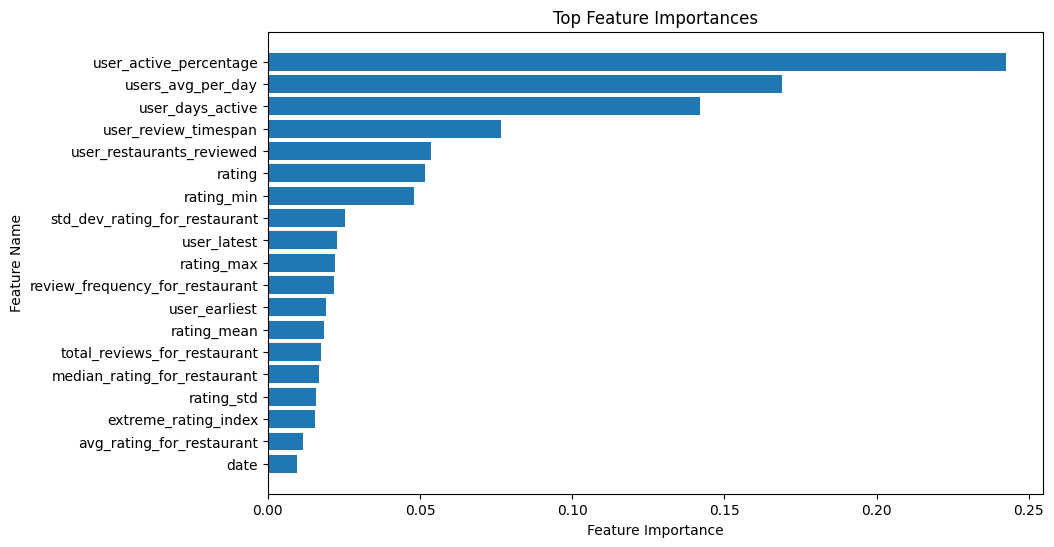

,Feature,Importance
18,user_active_percentage,0.242486
17,users_avg_per_day,0.169054
15,user_days_active,0.142106
16,user_review_timespan,0.076741
8,user_restaurants_reviewed,0.053705
0,rating,0.051775
10,rating_min,0.047920
4,std_dev_rating_for_restaurant,0.025396
14,user_latest,0.022853
11,rating_max,0.022106


In [68]:
import xgboost as xgb
import pandas as pd
import matplotlib.pyplot as plt

# Train XGBoost model
xgclf = xgb.XGBClassifier()
xgclf.fit(new_X_train, y_train)

# Get feature importance
feature_importance = xgclf.feature_importances_
feature_names = new_X_train.columns

# Convert to DataFrame
feat_imp_df = pd.DataFrame({'Feature': feature_names, 'Importance': feature_importance})
feat_imp_df = feat_imp_df.sort_values(by='Importance', ascending=False)

# Plot feature importance
plt.figure(figsize=(10, 6))
plt.barh(feat_imp_df['Feature'][:20], feat_imp_df['Importance'][:20])
plt.xlabel('Feature Importance')
plt.ylabel('Feature Name')
plt.title('Top Feature Importances')
plt.gca().invert_yaxis()
plt.show()

# Display the features
feat_imp_df

In [ ]:
# checking versions (sync with kaggle if using)
import sys
import numpy as np
import pandas as pd
import sklearn

print("Python Version:", sys.version)
print("NumPy Version:", np.__version__)
print("Pandas Version:", pd.__version__)
print("Scikit-Learn Version:", sklearn.__version__)

Python Version: 3.12.0 (tags/v3.12.0:0fb18b0, Oct  2 2023, 13:03:39) [MSC v.1935 64 bit (AMD64)]
NumPy Version: 1.26.3
Pandas Version: 2.2.1
Scikit-Learn Version: 1.5.0
